# Grayscale 3D CNN

In [1]:
!pip install tensorflow_docs
!pip install mediapipe
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 11.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pickle
import mediapipe as mp
from google.colab.patches import cv2_imshow
import uuid
import cv2
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [4]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
#val_batch_size = 1

min_frame_count = 25

resume = False # Сохранённая модель или с нуля?
lr = 0.0001
momentum = 0.0001
epoches = 15
save = False

In [28]:
annotations_file = "/content/drive/MyDrive/slovo/SLOVO_DATAFRAME.tsv" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv"
video_dir = "/content/drive/MyDrive/slovo/slovo" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo"
train_path = "/content/drive/MyDrive/slovo/datasets/train"
test_path = "/content/drive/MyDrive/slovo/datasets/test"
IMG_SIZE = 112

In [6]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<19,'train', 'test')
video_labels = video_labels[video_labels.text.isin(["слон", "пингвин"])]
video_labels.tail(5)

,attachment_id,text,user_id,height,width,length,begin,end,group_rank,dataset
15391,d7daaee6-284b-47bd-a304-e43df5d5eb01,пингвин,0a11105fbfa6d452b86187db53b753e2,636,360,96.0,11,67,18,train
15394,1d269e1e-f359-423c-b7ba-3aa42ed3444d,слон,012015303772a32f4d91adec2929cbae,640,360,112.0,35,97,19,test
15412,6bd6120e-9896-48db-afb6-9e01713c6f25,слон,0a11105fbfa6d452b86187db53b753e2,636,360,107.0,9,84,20,test
15419,e61c12a9-f727-441d-86e8-a9b854decd3e,пингвин,3018b64d2c938f5b6a0826dfdf486f2c,640,360,165.0,32,111,19,test
15445,2eca9c1e-103c-4a23-98c8-1e994fe76762,пингвин,e0ca58d03fc73a305046edcdf7ef7492,360,640,109.0,18,65,20,test


In [7]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 2. Example classes: ('пингвин', 'слон')


In [8]:
classes.index('слон')

1

In [9]:
mp_face = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_detection_model = '/content/face_detection_yunet_2023mar.onnx'
score_threshold = 0.9
nms_threshold = 0.3
top_k = 5000
scale = 1
detector = cv2.FaceDetectorYN.create(
                  face_detection_model,
                  "",
                  (320, 320),
                  score_threshold,
                  nms_threshold,
                  top_k
              )

In [10]:
class VideoDataset(Dataset):
    def __init__(self, video_labels, video_dir, IMG_SIZE, min_frame_count, ds_type = "test"):
        super(VideoDataset, self).__init__()
        self.video_labels = video_labels
        self.video_dir = video_dir
        self.IMG_SIZE = IMG_SIZE
        self.min_frame_count = min_frame_count
        self.video_data=[]
        self.video_label=[]
        for i in video_labels[video_labels.dataset==ds_type].index:
          frames, label = self.get_video_and_label(i)
          if frames is not None:  # В некоторых видео не может определить лицо mimetype?
              self.video_data.append(frames)
              self.video_label.append(classes.index(label))


    def __len__(self):
        return len(self.video_label)

    def crop_center_square(self, image, min_y, max_y, min_x, max_x):
        image = image[min_y : max_y, min_x : max_x]
        new_size = max(image.shape[0], image.shape[1])
        blank_image = np.zeros((new_size,new_size,3), np.uint8)
        blank_image[0 : image.shape[0], 0 : image.shape[1]] = image
        blank_image = cv2.resize(blank_image, (self.IMG_SIZE, self.IMG_SIZE))
        return blank_image


    def crop_coordinates(self, image):
      shape = image.shape
      with mp_face.FaceMesh(static_image_mode=True,
                                              max_num_faces=1,
                                              refine_landmarks=True,
                                              min_detection_confidence=0.5) as face_mesh:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        has_result = False
        i=0
        while not has_result:
          results = face_mesh.process(image)
          i+=1
          if i==5 or results.multi_face_landmarks is not None:
            has_result = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image.flags.writeable = True
        if results.multi_face_landmarks is None:
          img1Width = int(image.shape[1]*scale)
          img1Height = int(image.shape[0]*scale)

          tm = cv2.TickMeter()
          tm.start()
          detector.setInputSize((img1Width, img1Height))
          faces1 = detector.detect(image)
          tm.stop()
          if faces1[1] is not None:
            face_height = faces1[1][0][3]
            face_width = faces1[1][0][2]
            new_size = min(image.shape[0], image.shape[1], face_height*4)
            y_left =  faces1[1][0][1]
            x_left = faces1[1][0][0]
            min_x = max(int((x_left + face_width/2) - new_size/2),0)
            max_x = min(int((x_left + face_width/2) + new_size/2), image.shape[1])
            min_y = max(int((y_left + face_height) - new_size/2), 0)
            max_y = max(int((y_left + face_height) + new_size/2), image.shape[0])
            return min_y, max_y, min_x, max_x
          new_size = min(image.shape[:2])
          min_x = int(image.shape[1]/2 - new_size/2)
          max_x = int(image.shape[1]/2 + new_size/2)
          min_y = int(image.shape[0]/2 - new_size/2)
          max_y = int(image.shape[0]/2 + new_size/2)
          return min_y, max_y, min_x, max_x
        face_ls = results.multi_face_landmarks[0].landmark
        y_coordinates = [idx.y for idx in face_ls]
        x_coordinates = [idx.x for idx in face_ls]
        max_y, min_y = max(y_coordinates), min(y_coordinates)
        max_x, min_x = max(x_coordinates), min(x_coordinates)
        middle_x = (min_x + (max_x-min_x)/2) * shape[1]
        delta = max_y-min_y
        max_y, min_y = min(int((max_y+3*delta)*shape[0]),shape[0]), max(int((min_y-delta)*shape[0]),0)
        height = max_y - min_y
        max_x, min_x = min(int(max_x*shape[1]) + height//2, shape[1]) , max(int(min_x*shape[1]) - height//2,0)
      return min_y, max_y, min_x, max_x

    def load_video(self, path, begin, end, max_frames=0, label=None):
        cap = cv2.VideoCapture(path)
        frames = []
        gray_frames = []
        min_y, max_y, min_x, max_x = 0, 0, 0, 0
        frame_index=begin+1
        while True and frame_index <= end:
          cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
          ret, frame = cap.read()
          if not ret:
            break
          if frame_index==begin+1:
            cc = self.crop_coordinates(frame)
            if cc is None:
             begin+=1
            else:
             min_y, max_y, min_x, max_x = cc
          if (min_y, max_y, min_x, max_x) != (0, 0, 0, 0):
            frame = self.crop_center_square(frame, min_y, max_y, min_x, max_x)
            frames.append(frame)
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frames.append(gray_frame)
            frame_index+=1
          if len(frames) == max_frames:
           break

        cap.release()
        if len(gray_frames)==0:
          print(f"No frames extracted from: {path}")
          return None
        totalt_frame_cnt = len(gray_frames)
        if totalt_frame_cnt < self.min_frame_count:
          all_idxs = list(range(totalt_frame_cnt))
          add_idxs = random.choices(range(totalt_frame_cnt), k=self.min_frame_count-totalt_frame_cnt)
          all_idxs.extend(add_idxs)
        else:
          all_idxs = random.sample(range(totalt_frame_cnt), k=self.min_frame_count)
        #gray_frames = [gray_frames[i] for i in sorted(all_idxs)]
        frames = [frames[i] for i in sorted(all_idxs)]
        return torch.from_numpy(np.array(frames))

    def get_video_and_label(self, idx):
        filename  = os.path.join(self.video_dir, self.video_labels[self.video_labels.index==idx]['attachment_id'][idx]+".mp4")
        label = self.video_labels[self.video_labels.index==idx]['text'][idx]
        begin = self.video_labels[self.video_labels.index==idx]['begin'][idx]
        end = self.video_labels[self.video_labels.index==idx]['end'][idx]
        #print(f"Load {filename}")
        frames = self.load_video(filename, begin, end, label=label) # Загрузка видео!!!!
        return frames, label

    def __getitem__(self, index):
        frames= self.video_data[index]
        label=self.video_label[index]
        frames=torch.Tensor(frames)
        return frames.permute(3,0, 1,2), label

* The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).
* The __len__ function returns the number of samples in our dataset.
* The __getitem__ function loads and returns a sample from the dataset at the given index idx.

In [11]:
video_labels[video_labels.index==15445]['text'][15445]

'пингвин'

In [29]:
min_frame_count = 25
train_batch_size=1
test_batch_size=1

train_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
test_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

train_dataloader = DataLoader(VideoDataset(video_labels, video_dir, IMG_SIZE, min_frame_count, ds_type = "train"), batch_size=train_batch_size, shuffle=True, **train_kwargs)
test_dataloader = DataLoader(VideoDataset(video_labels, video_dir, IMG_SIZE, min_frame_count, ds_type = "test"), batch_size=test_batch_size, shuffle=True, **test_kwargs)

torch.Size([1, 3, 25, 112, 112])
torch.Size([1, 25, 3, 112, 112])
torch.Size([1, 3, 25, 112, 112])
torch.Size([1, 25, 3, 112, 112])
torch.Size([1, 3, 25, 112, 112])
torch.Size([1, 25, 3, 112, 112])


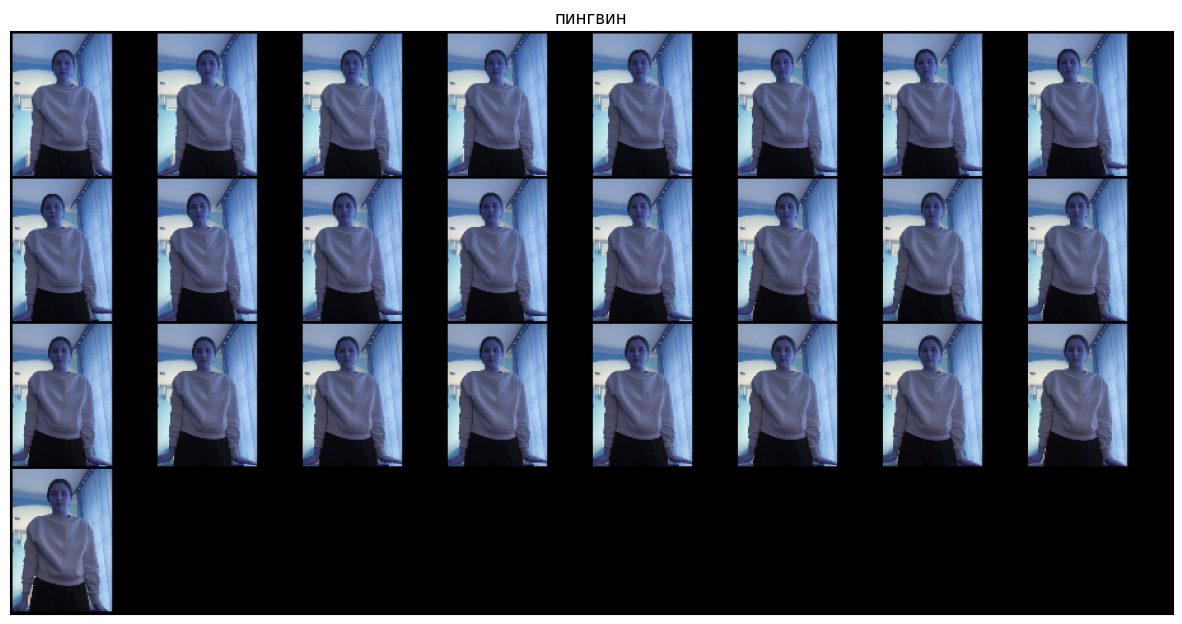

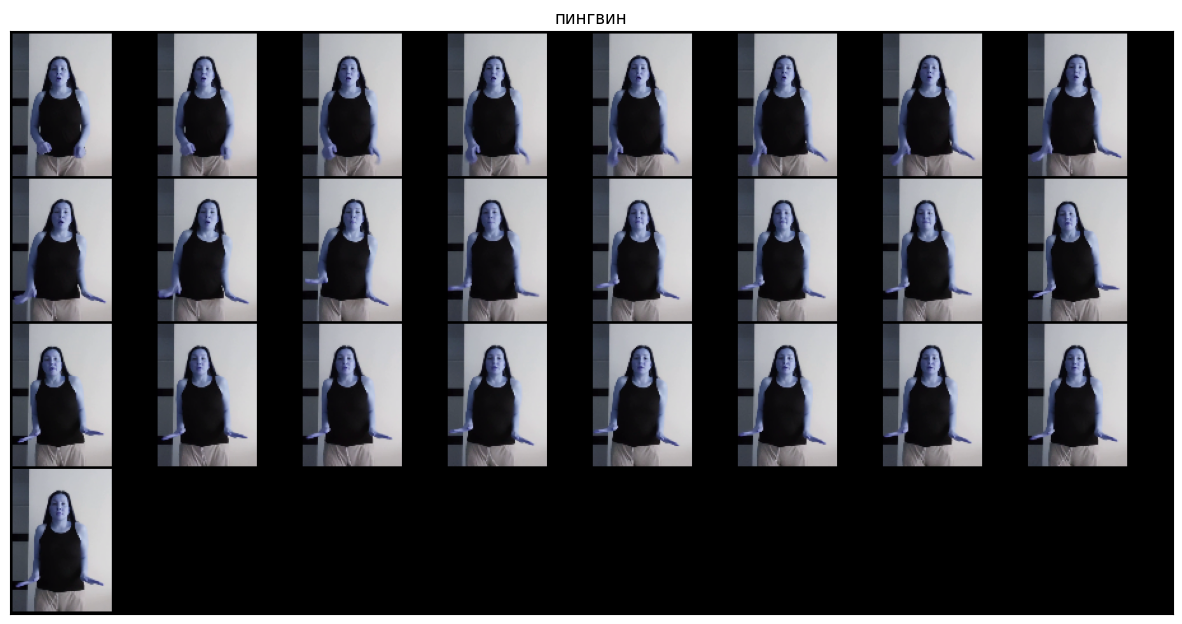

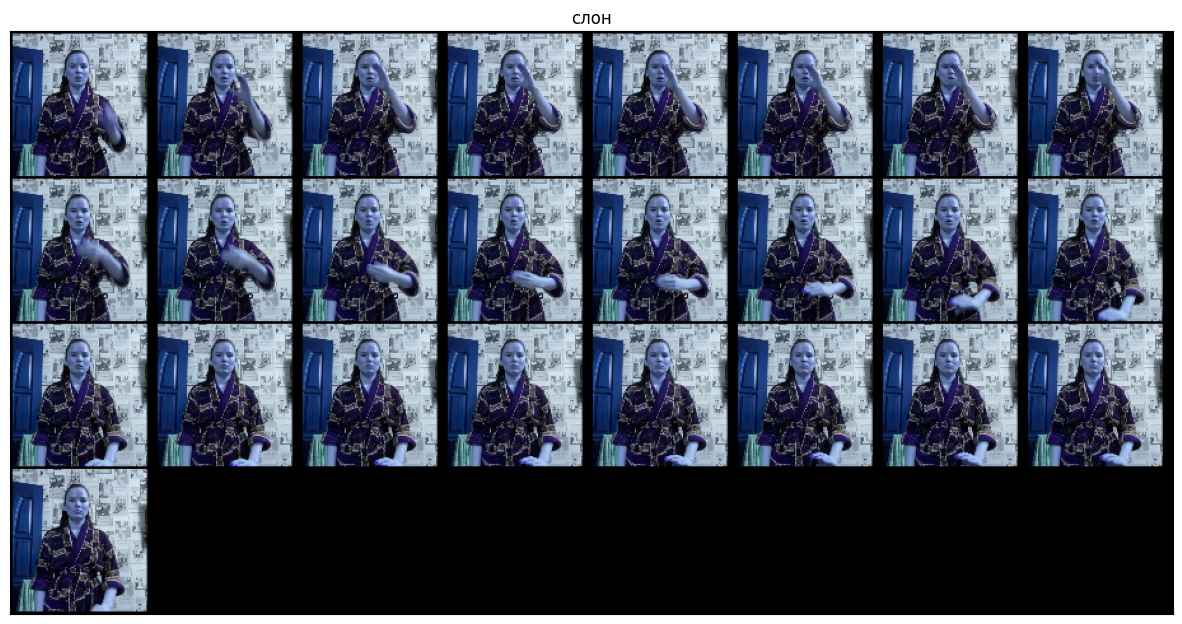

In [30]:
def show(imgs, label):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15, 15))
    plt.title(label)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

test_dl = iter(test_dataloader)
for i in range(3):
  frames, labels = next(test_dl)
  print(frames.shape)
  frames = frames.permute(0,2,1,3,4)
  print(frames.shape)
  show(torchvision.utils.make_grid(frames[0]), classes[labels.item()])


In [31]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(device)

cuda


In [32]:
frames, labels = next(iter(test_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 224, 224])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([0])


In [43]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
for param in resnet.parameters():
    param.requires_grad = False
print(resnet)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [44]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class) # reset out features fir the last layer to the number of classes
resnet.fc

Linear(in_features=512, out_features=2, bias=True)

In [45]:
# resnet.stem[0].in_channels = 1 # reset in_channels to 1 (for grayscale)
# resnet.stem

In [46]:
frames.shape

torch.Size([1, 3, 25, 112, 112])

In [47]:
frames, labels = next(iter(test_dataloader))
frames = frames.to(device)
resnet.to(device)
print(f"Output shape: {resnet(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 2])


In [48]:
#Constructing LOSS target functions. Select an optimizer. Learning rate change
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(resnet.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)

In [49]:
def check_some_predictions(n):
  test_dl = iter(test_dataloader)
  for i in range(n):
    frames, labels = next(test_dl)
    frames=frames.to(device)
    true_label = classes[labels.item()]
    output = resnet(frames/255)
    pred_label = classes[torch.argmax(output, 1)]
    print(f"Label: {true_label}; Predicted: {pred_label}")
check_some_predictions(4)

Label: пингвин; Predicted: слон
Label: слон; Predicted: слон
Label: слон; Predicted: слон
Label: пингвин; Predicted: слон


In [50]:
print(resnet)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [51]:
def train(epoch):
  total_loss = []
  pbar = tqdm(train_dataloader, desc=f'Train Epoch{epoch}/{epoches}')
  for data, target in pbar:
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()  # Model Parameters Gradient Clear
    output = resnet(data/255)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    total_loss.append(loss.item())
    pbar.set_description(f'Train Epoch:{epoch}/{epoches} train_loss:{round(np.mean(total_loss), 4)}')
    #scheduler.step()

def test(epoch):
  global best_acc
  test_loss = []
  correct=0
  total=0
  resnet.eval()
  pbar = tqdm(test_dataloader, desc=f'Test Epoch{epoch}/{epoches}', mininterval=0.3)
  for data, target in pbar:
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
      output = resnet(data/255)
    loss = criterion(output, target)
    test_loss.append(loss)
    pred = torch.argmax(output, 1)
    correct += (pred == target.item()).sum().float()
    total += len(target)
    predict_acc = correct / total
    pbar.set_description(f'Test Epoch:{epoch}/{epoches} acc:{predict_acc:.3f}')
  if save: # and predict_acc > best_acc:
    best_acc = predict_acc if predict_acc > best_acc else best_acc
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                #'loss': round(np.mean(test_loss), 2)
            },
                "/content/drive/MyDrive/slovo/weights" + f'/3DCNN-Epoch-{epoch}-Test_acc-{predict_acc:.3f}.pth')
  check_some_predictions(4)

In [52]:
previous_epochs = 0
if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

for epoch in range(previous_epochs+1, previous_epochs + epoches + 1):
  train(epoch)
  if epoch % 1 == 0:
    test(epoch)

Test Epoch:1/15 acc:0.750: 100%|██████████| 4/4 [00:00<00:00, 23.49it/s]


Label: слон; Predicted: слон
Label: пингвин; Predicted: слон
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин


Test Epoch:2/15 acc:0.750: 100%|██████████| 4/4 [00:00<00:00, 23.62it/s]


Label: пингвин; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: слон; Predicted: слон


Test Epoch:3/15 acc:0.750: 100%|██████████| 4/4 [00:00<00:00, 23.02it/s]


Label: слон; Predicted: пингвин
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: пингвин; Predicted: пингвин


Test Epoch:4/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.92it/s]


Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин


Test Epoch:5/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 23.21it/s]


Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин


Test Epoch:6/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.63it/s]


Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин


Test Epoch:7/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.63it/s]


Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон


Test Epoch:8/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 23.12it/s]


Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон


Test Epoch:9/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 23.17it/s]


Label: слон; Predicted: слон
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: пингвин; Predicted: пингвин


Test Epoch:10/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.89it/s]


Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон


Test Epoch:11/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.44it/s]


Label: пингвин; Predicted: пингвин
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: слон; Predicted: слон


Test Epoch:12/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.21it/s]


Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин


Test Epoch:13/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.70it/s]


Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин


Test Epoch:14/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.58it/s]


Label: слон; Predicted: слон
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: пингвин; Predicted: пингвин


Test Epoch:15/15 acc:1.000: 100%|██████████| 4/4 [00:00<00:00, 22.61it/s]


Label: слон; Predicted: слон
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Label: пингвин; Predicted: пингвин
